In [1]:
import os, sys

import numpy as np
import pandas as pd

from os.path import join

from ikmeans import IKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pwd = os.getcwd()
data_dir = join(pwd, 'data/')
need_normalization = False
need_standardization = False
need_pca = False
filename = 'cloud.csv'
datapath = join(data_dir, filename)
num_comps = 2
num_clusters = 10
num_iterations = 500

In [3]:
# f = open('data/data.csv')
# lines = f.read()
# print(type(lines))
# new_lines = ''
# for line in lines:
#     new_lines += str(line.encode('utf-8').strip())
# print(len(new_lines))

In [4]:
df = pd.read_csv(
    datapath, 
    low_memory=False,
    encoding='utf-8',
#     sep=',',
    header=None,
)

In [5]:
print(len(df))

1024


In [6]:
print(df.head())

     0      1        2       3         4       5       6      7      8  \
0  3.0  140.0  43.5000  0.0833  862.8417  0.0254  3.8890  163.0  240.0   
1  3.0  135.0  41.9063  0.0790  690.3291  0.0259  3.8340  167.0  239.0   
2  2.0  126.0  21.0586  0.0406  308.3583  0.0684  3.1702  174.0  240.0   
3  4.0  197.0  77.4805  0.0890  874.4709  0.0243  3.9442  155.0  239.0   
4  7.0  193.0  88.8398  0.0884  810.1126  0.0223  3.9318  150.0  236.0   

          9  
0  213.3555  
1  213.7188  
2  227.5859  
3  197.2773  
4  186.0195  


In [7]:
print(df.dtypes)

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9    float64
dtype: object


In [8]:
columns = df.columns.tolist()
cols = columns
# cols = columns[1:]
# cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Fare']
# cols = columns[:-1]
# cols = ['Passenger Count', 'Adjusted Passenger Count']
# cols = columns[1:]
cols = columns[:]
df = df[cols]
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.fillna(0)
df = df.replace([-np.inf, np.inf], np.nan)
df = df.dropna()
df = df.loc[:, (df != 0).any(axis=0)]
print(len(df))
print(df.dtypes)

1024
0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9    float64
dtype: object


In [9]:
df = df.sample(
    frac=1.0,
    random_state=1,
)
df = df.reset_index(drop=True)

In [10]:
if need_normalization is True:
    normalizer = StandardScaler()
    tmp = normalizer.fit_transform(df)
    df = pd.DataFrame(tmp, columns=df.columns)
elif need_standardization is True:
    scaler = MinMaxScaler()
    tmp = scaler.fit_transform(df)
    df = pd.DataFrame(tmp, columns=df.columns)

In [11]:
X = df
if need_pca is True:
    pca = PCA(
        n_components=num_comps,
        svd_solver='auto',
    )
    X = pca.fit_transform(X)
else:
    X = X.to_numpy()

In [12]:
for x in X:
    for a in x:
        if np.isinf(a):
            print(x)

In [13]:
data = X
print(data[:5])
print(data.shape)

[[5.000000e+00 1.600000e+01 5.730500e+00 1.700000e-03 8.167000e-01
  5.326000e-01 8.504000e-01 2.400000e+02 2.460000e+02 2.451914e+02]
 [5.000000e+00 1.640000e+02 1.994530e+01 3.720000e-02 2.889458e+02
  6.800000e-02 3.070100e+00 1.900000e+02 2.460000e+02 2.386445e+02]
 [5.000000e+00 1.990000e+02 2.408200e+01 4.600000e-02 3.770042e+02
  6.010000e-02 3.253000e+00 1.700000e+02 2.470000e+02 2.347109e+02]
 [3.000000e+00 3.400000e+01 5.597700e+00 9.900000e-03 2.434170e+01
  2.243000e-01 1.972400e+00 2.340000e+02 2.520000e+02 2.490117e+02]
 [4.000000e+00 8.300000e+01 1.900390e+01 2.640000e-02 1.048375e+02
  8.060000e-02 2.879200e+00 2.050000e+02 2.460000e+02 2.366992e+02]]
(1024, 10)


In [14]:
models = ['ikmeans', 'kmeans']
inits = {
    'kmeans': 'k-means++',
    'ikmeans': 'ikmeans',
}

In [15]:
ikmeans = IKMeans(
    n_clusters=num_clusters,
    max_iter=num_iterations,
    verbose=0,
    init = 'ikmeans',
)

In [16]:
kmeans = IKMeans(
    n_clusters=num_clusters,
    max_iter=num_iterations,
    init='kmeans',
#     algorithm='auto',
#     n_init=50,
    verbose=0,
)

In [17]:
algorithms = {
    'kmeans': kmeans,
    'ikmeans': ikmeans,
}

Iterations for convergence: 2
11720851.588266956


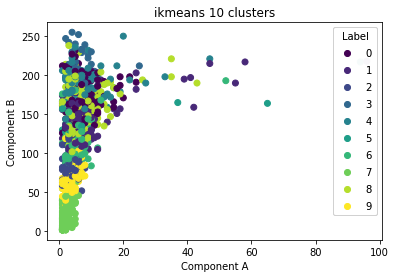

Iterations for convergence: 2
12422101.742567465


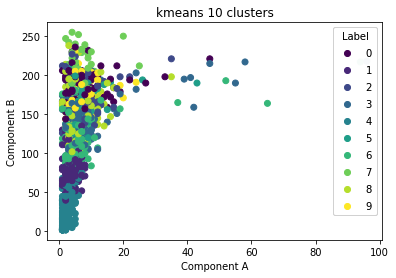

In [18]:
for model in models:
    algorithm = algorithms[model].fit(data)
    centers = algorithm.cluster_centers_
    labels = algorithms[model].predict(data)
    fig, ax = plt.subplots()
    print((algorithms[model].inertia_))
    scatter = plt.scatter(
        X[:, 0],
        X[:, 1],
        c=labels,
    )
    handles, labels = scatter.legend_elements()
    legend = ax.legend(
        handles,
        labels,
        loc='upper right',
        title='Label',
    )
    ax.add_artist(legend)
    plt.title(model+' '+str(num_clusters)+ ' clusters')
    plt.xlabel('Component A')
    plt.ylabel('Component B')
    plt.show()